In [34]:
import pandas as pd
import numpy as np
import cv2

from PIL import Image, ImageStat
from matplotlib import pyplot as plt
from os.path import exists

# for inventory item detection

In [21]:
def edge_detection(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
#     img = cv2.blur(img, (3,3))
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.Canny(img, threshold1=50, threshold2=200, apertureSize=5)
#     img = cv2.blur(img, (2,2))
    img = cv2.blur(img, (3,3))
    return img

def inventory_line_detection(img):
    img_inventory_edge = edge_detection(img)
    
    img_horizontal = img_inventory_edge.copy()
    img_vertical = img_inventory_edge.copy()

    line_length = 50
    horizontal_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (line_length,1))
    vertical_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,line_length))

    cv2.erode(img_horizontal, horizontal_struct, img_horizontal)
    cv2.dilate(img_horizontal, horizontal_struct, img_horizontal)

    cv2.erode(img_vertical, vertical_struct, img_vertical)
    cv2.dilate(img_vertical, vertical_struct, img_vertical)

    result = cv2.add(img_horizontal, img_vertical)
    return result

def find_slot_locations(inventory_filtered, slot_gray):
    matched_slots = cv2.matchTemplate(inventory_filtered, slot_gray, cv2.TM_CCORR_NORMED)
    
    threshold = 0.7
    slot_locations = []
    slots_min_x = (int) (1920/3)
    min_distance = 50
    slot_locations_filtered = []
    
    for y in range(matched_slots.shape[0]):
        for x in range(matched_slots.shape[1]):
            if matched_slots[y][x] > threshold:
                if x > slots_min_x:
                    slot_locations.append((x,y))
    
    # filter number of locations
    for x,y in slot_locations:
        add_slot = True
        for s in slot_locations_filtered:
            if abs(s[0]-x) < min_distance and abs(s[1]-y) < min_distance:
                add_slot = False
                break
        if add_slot == True:
            slot_locations_filtered.append((x,y))
            
    return slot_locations_filtered

def draw_slots_on_image(img, slots):
    img_with_slots = img.copy()
    for x,y in slots:
        img_with_slots = cv2.circle(img_with_slots, (x, y), radius=5, color=(255,0,0), thickness=-1)
    return img_with_slots

def get_items_from_inventory(inventory, slots):
    slot_size = 64 # in pixels, for FHD resolution
    items = []
    
    for s in slots:
        items.append(inventory[s[1]:s[1]+slot_size, s[0]:s[0]+slot_size])
        
    return items

# to predict the item image

In [134]:
def load_icons_from_disk(verbose=False):
    global all_items_df
    
    icons = []
    for index,item in all_items_df.iterrows():
        filename = path_grid_icons + item['id'] + filename_ending_grid_icon
        if exists(filename):
            icons.append(np.asarray(Image.open(filename)))
        else:
            icons.append([])
            if verbose:
                print(f"File {filename} does not exist.")
    return icons

def run_sift(img):
    global sift
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp,des = sift.detectAndCompute(gray,None)
    return kp,des

def create_all_descriptors():
    global icons
    descriptors = []
    for icon in icons:
        if len(icon) == 0:
            descriptors.append(None)
            continue
        kp,des = run_sift(icon)
        descriptors.append(des)
    return descriptors

def predict_icon(img):
    global icons, bf, descriptors
    distances = []
    
    kp,des = run_sift(img)

    for i in range(len(icons)):
        if descriptors[i] is None:
            distances.append(999999)
            continue

        matches = bf.match(des, descriptors[i])

        distance = 0
        for match in matches:
            distance += (match.distance**2)/len(matches)
        distances.append(distance)

    prediction = np.argmin(distances)
    min_distance = min(distances)
    
    # filter predictions
#     threshold = 60000
#     if min_distance > threshold:
#         return -1,-1
    
    return prediction,min_distance

def predict_all_icons(images):
    predictions = []
    distances = []
    for item in images:
        p,d = predict_icon(item)
        predictions.append(p)
        distances.append(d)
    return predictions,distances

# find items in inventory

In [28]:
# paths
path_icons = './icons/'
path_images = './images/'
path_grid_icons = './grid_icons/'
path_data = './data/'

filename_ending_grid_icon = '-grid-image.jpg'

In [38]:
# load inventory image
img_inventory = Image.open(path_images + 'inventar4.png')
img_inventory = np.asarray(img_inventory)

# filter inventory image
inventory_filtered = inventory_line_detection(img_inventory)

In [39]:
# load and filter slot reference image
img_slot = Image.open(path_images + 'slot_empty.png')
img_slot = np.asarray(img_slot)
img_slot_gray = cv2.cvtColor(img_slot, cv2.COLOR_BGR2GRAY)

In [40]:
# find slots in inventory
slot_locations = find_slot_locations(inventory_filtered, img_slot_gray)

# draw slots on image
img_inventory = draw_slots_on_image(img_inventory, slot_locations)

In [41]:
# get item images from inventory
item_images = get_items_from_inventory(img_inventory, slot_locations)

# predict items

In [127]:
icons = []
descriptors = []
all_items_df = None
predictions = []
distances = []

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

# get descriptors of all items
all_items_df = pd.read_csv(path_data + 'all_items.csv')
icons = load_icons_from_disk()
descriptors = create_all_descriptors()

In [136]:
# predict each item from inventory
predictions,distances = predict_all_icons(item_images)
predictions_df = pd.DataFrame({'slot_x': 0, 'slot_y': 0, 'predicted_item': predictions, 'distance': distances})

In [139]:
for i in range(len(predictions_df)):
    predictions_df.loc[i,'slot_x'] = slot_locations[i][0]
    predictions_df.loc[i,'slot_y'] = slot_locations[i][1]

In [141]:
# save predictions to file
predictions_df.to_csv(path_data + 'predictions_inventar4.csv', index=False)

# debugging stuff

In [123]:
# threshold = 200000
# predictions_filtered = []
# for prediction in predictions:
#     if prediction[1] > threshold:
#         predictions_filtered.append((0, -1))
#     else:
#         predictions_filtered.append(prediction)

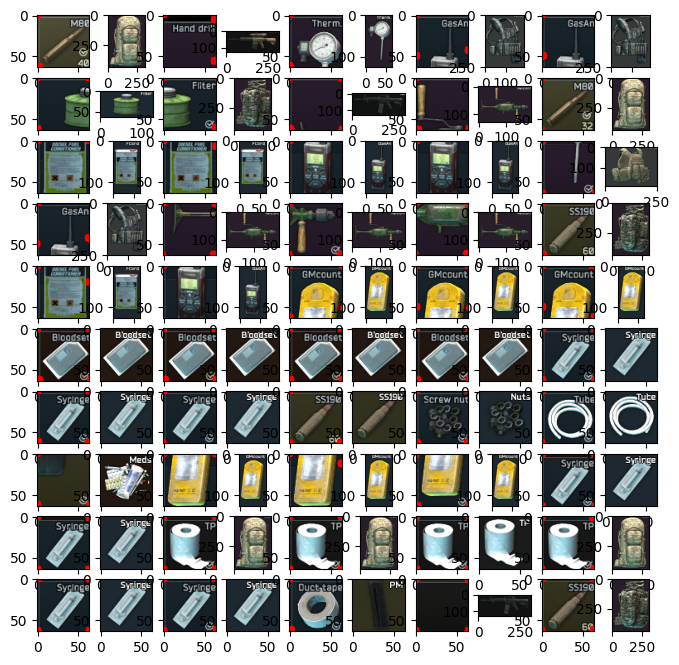

In [129]:
predictions_here = predictions

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(0,columns*rows,2):
    img = item_images[(int) (i/2)]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    img = icons[predictions[(int) (i/2)]]
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(img)
plt.show()

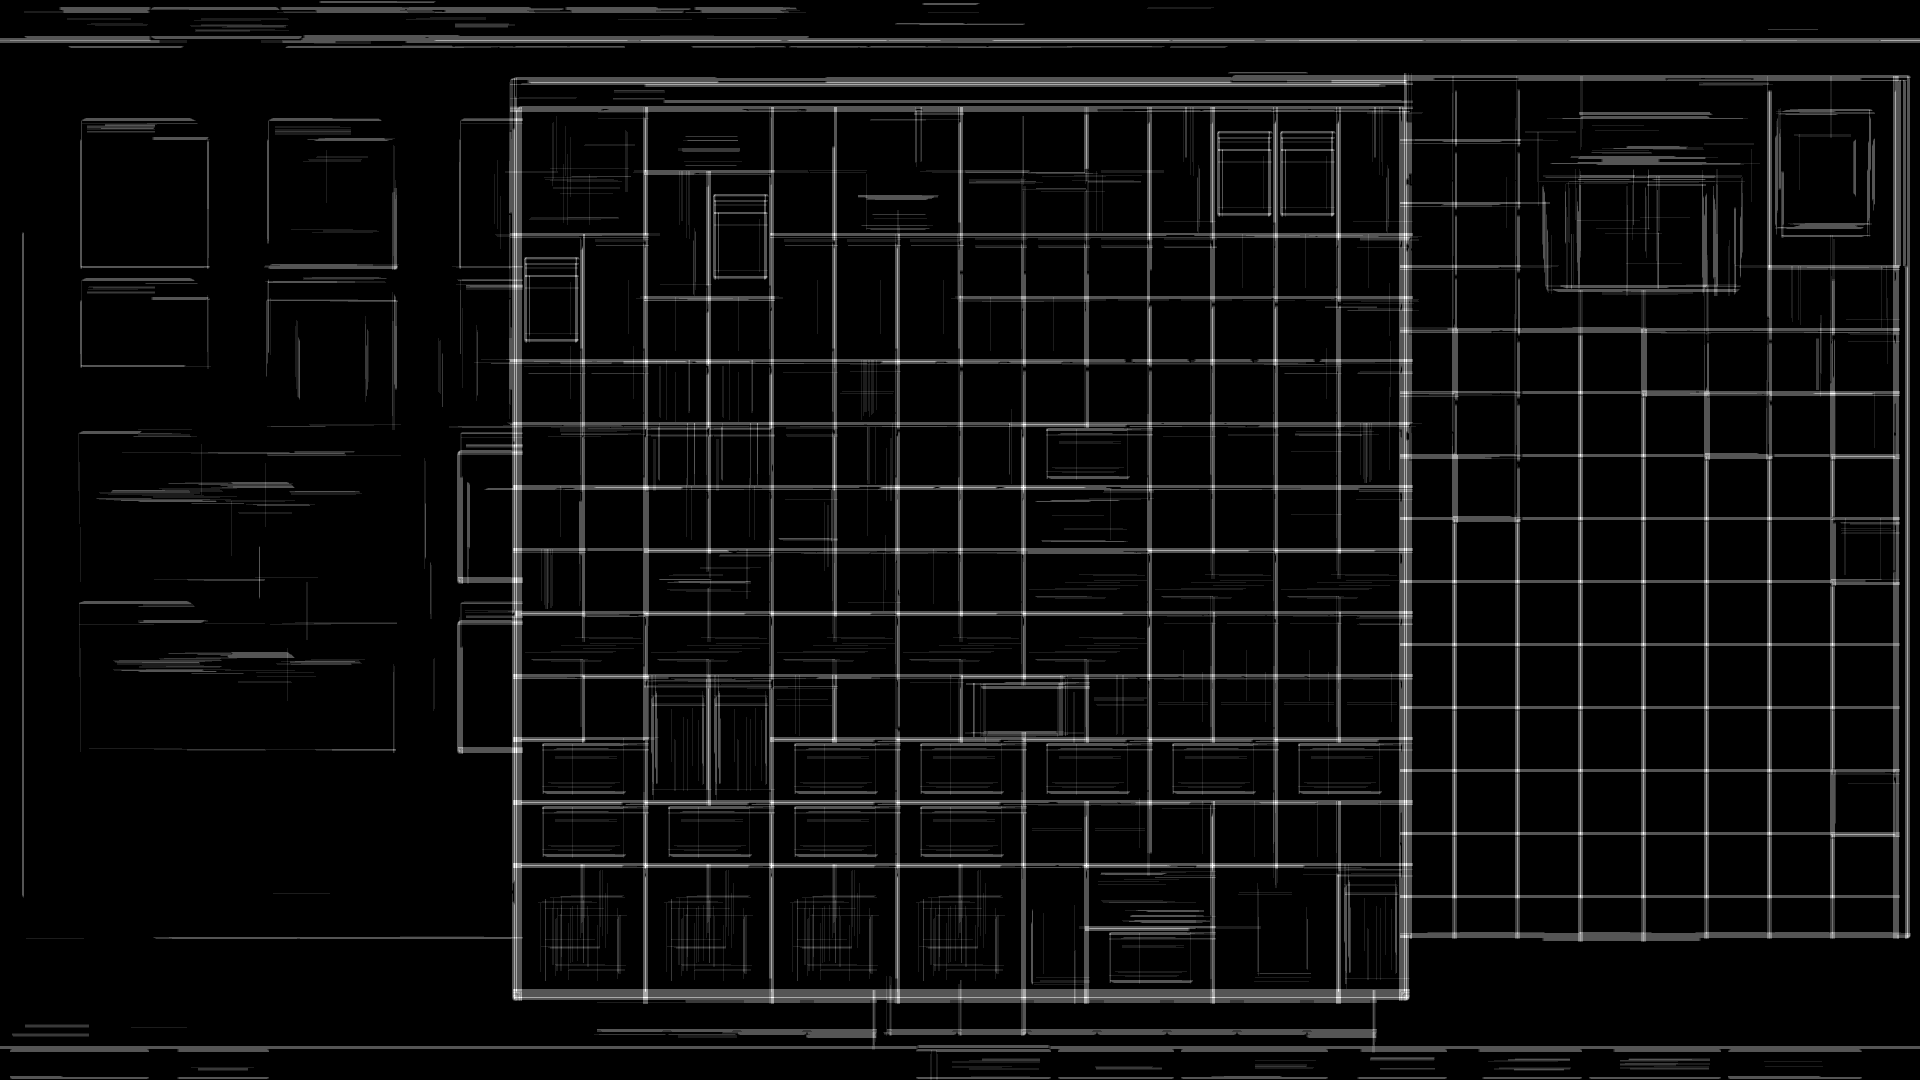

In [122]:
Image.fromarray(inventory_filtered)

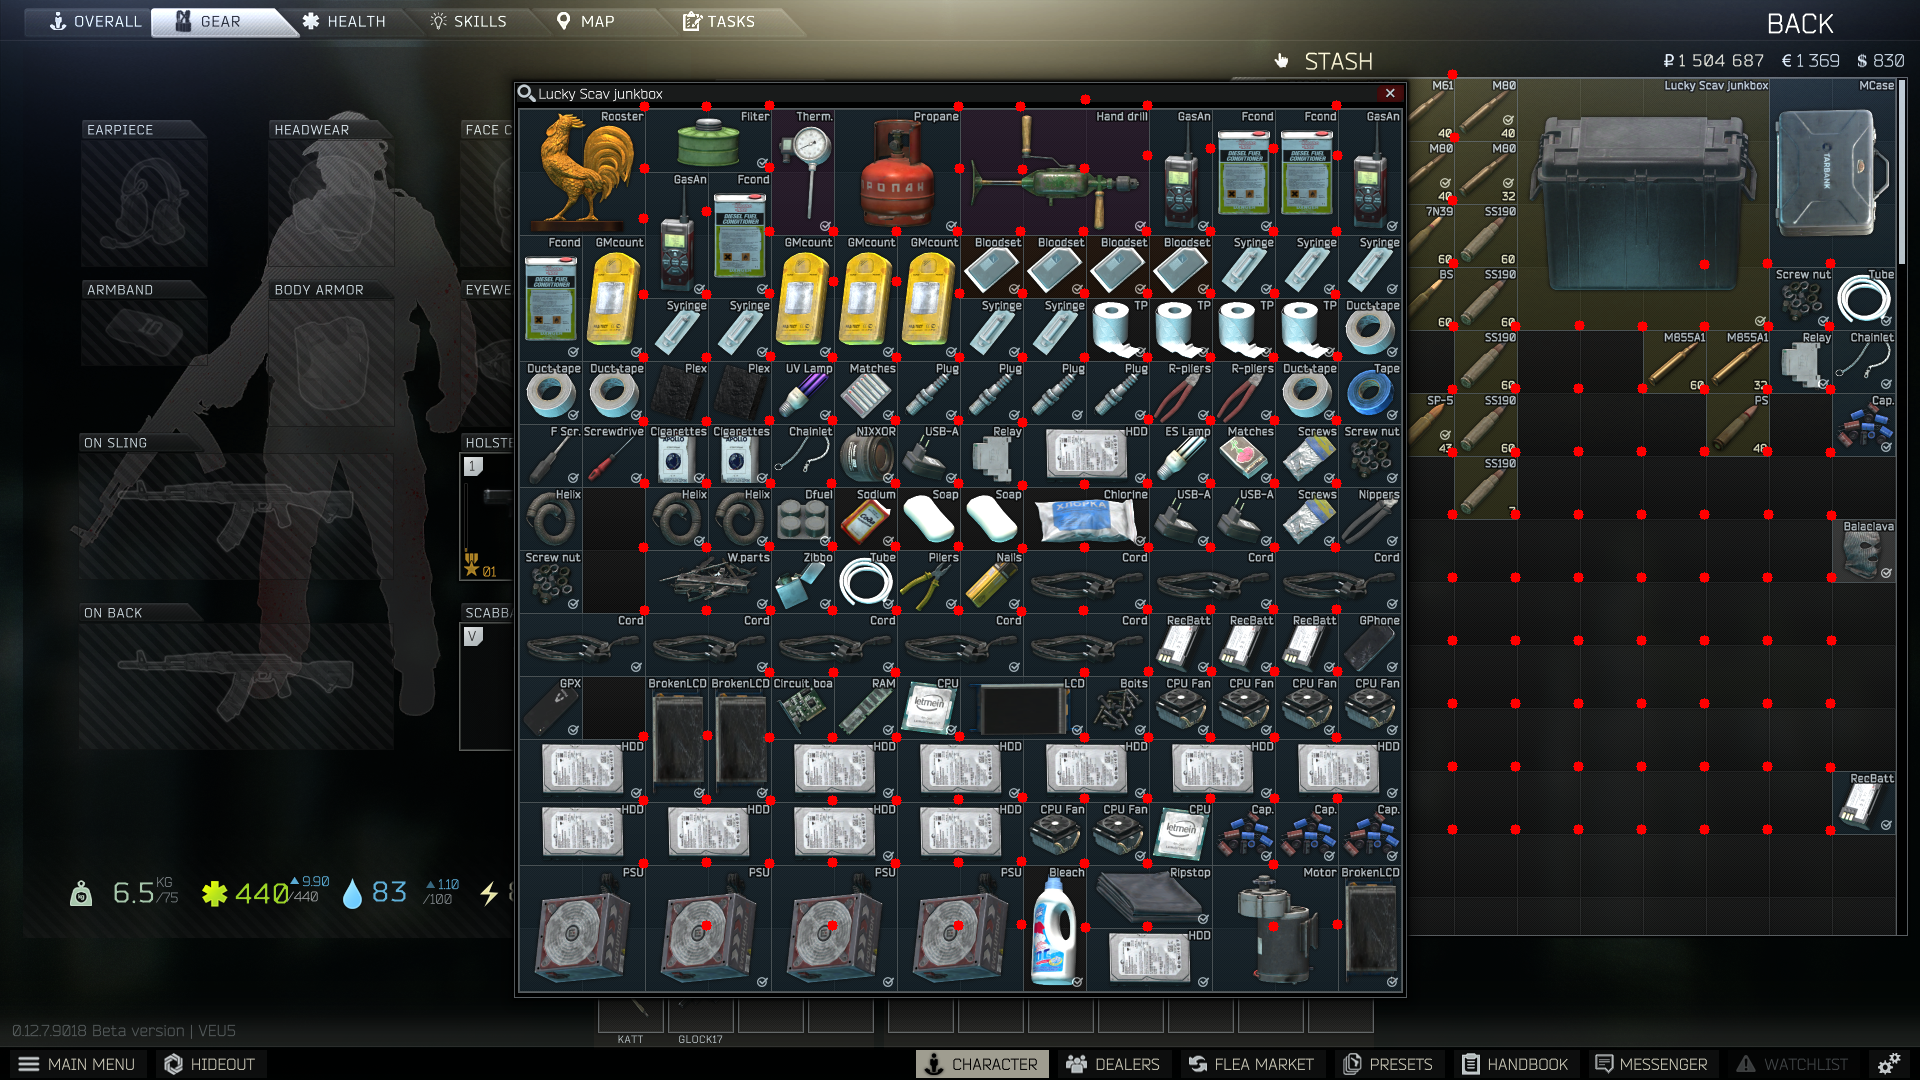

In [125]:
# Image.fromarray(img_slot_np_edge)
# Image.fromarray(res)
# plt.imshow(res[3], cmap='gray')
Image.fromarray(img_inventory)
# Image.fromarray(hough)

In [140]:
predictions_df

,slot_x,slot_y,predicted_item,distance
0,1452,74,1384,68170.144556
1,1085,99,2455,85551.545950
2,769,105,1703,38451.001016
3,1147,105,92,66751.777786
4,1336,105,92,66739.666621
...,...,...,...,...
214,832,925,204,100596.465589
215,958,925,204,93417.625570
216,1147,926,467,108301.024373
217,1273,926,1695,42904.902255
